<a href="https://colab.research.google.com/github/omkar-mohanty/3D-Classifier/blob/main/observation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, initializers
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Current Model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

z_dim = 100  # Latent space dimension

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

class Encoder(layers.Layer):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        self.conv1 = layers.Conv3D(30, 3, activation='relu', strides=2, padding='same')
        self.conv2 = layers.Conv3D(60, 3, activation='relu', strides=2, padding='same')
        self.flatten = layers.Flatten()
        # self.dense = layers.Dense(120, activation='relu')
        self.z_mean = layers.Dense(z_dim)
        self.z_log_var = layers.Dense(z_dim)
        self.z_dim = z_dim

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.flatten(x)
        # x = self.dense(x)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        z = layers.Lambda(sampling, output_shape=(self.z_dim,), name='z')([z_mean, z_log_var])
        return z_mean, z_log_var, z

class Decoder(layers.Layer):
    def __init__(self, z_dim):
        super(Decoder, self).__init__()
        self.dense = layers.Dense(7*7*7*60, activation='relu')
        self.reshape = layers.Reshape((7, 7, 7, 60))
        self.convT1 = layers.Conv3DTranspose(60, 3, activation='relu', strides=2, padding='same')
        self.convT2 = layers.Conv3DTranspose(30, 3, activation='relu', strides=2, padding='same')
        self.convT3 = layers.Conv3DTranspose(1, 3, activation='sigmoid', padding='valid')

    def call(self, inputs):
        x = self.dense(inputs)
        x = self.reshape(x)
        x = self.convT1(x)
        x = self.convT2(x)
        x = self.convT3(x)
        return x

class VAE3D(models.Model):
    def __init__(self, model_input_shape, z_dim):
        super(VAE3D, self).__init__()
        self.encoder = Encoder(z_dim=z_dim)
        self.decoder = Decoder(z_dim=z_dim)
        self.model_input_shape = model_input_shape

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        self.add_loss(self.vae_loss(inputs, reconstructed, z_mean, z_log_var))
        return reconstructed

    def vae_loss(self, inputs, reconstructed, z_mean, z_log_var):
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(inputs - reconstructed), axis=[1, 2, 3]))
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
        return reconstruction_loss + kl_loss

    def encode(self, inputs):
        z_mean, _, _ = self.encoder(inputs)
        return z_mean

# Model instantiation
model_input_shape = (30, 30, 30, 1)
model = VAE3D(model_input_shape=model_input_shape, z_dim=z_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, metrics=['accuracy'])

# Model Training

In [ ]:
import h5py
import numpy as np

# Load dataset (modelnet10)
file_path = '/content/drive/MyDrive/Colab Notebooks/ModelNet10_res30_raw.mat'
data = h5py.File(file_path)

train_data = np.transpose(data['train'])
test_data = np.transpose(data['test'])

def preprocess_data(data):
    # Extract labels from the first index
    labels = data[:, 0].astype('int32')

    # Remove the ID/label from each entry and reshape the rest into [30, 30, 30, 1]
    voxels = data[:, 1:].reshape((-1, 30, 30, 30, 1)).astype('float32')

    return voxels, labels

train_voxels, train_labels = preprocess_data(train_data)
test_voxels, test_labels = preprocess_data(test_data)


In [ ]:
model.fit(train_voxels, train_voxels, epochs=50, batch_size=200, validation_split=0.1)

Epoch 1/50
18/18 [==============================] - 25s 704ms/step - loss: 4069.5928 - accuracy: 0.8722 - val_loss: 3407.9971 - val_accuracy: 0.8455
Epoch 2/50
18/18 [==============================] - 5s 308ms/step - loss: 2424.8252 - accuracy: 0.8815 - val_loss: 3078.4175 - val_accuracy: 0.8455
Epoch 3/50
18/18 [==============================] - 5s 258ms/step - loss: 2220.8792 - accuracy: 0.8815 - val_loss: 3015.6372 - val_accuracy: 0.8455
Epoch 4/50
18/18 [==============================] - 5s 258ms/step - loss: 2044.4158 - accuracy: 0.8815 - val_loss: 2790.3198 - val_accuracy: 0.8455
Epoch 5/50
18/18 [==============================] - 5s 264ms/step - loss: 1869.2338 - accuracy: 0.8815 - val_loss: 2585.7222 - val_accuracy: 0.8455
Epoch 6/50
18/18 [==============================] - 5s 265ms/step - loss: 1723.5396 - accuracy: 0.8815 - val_loss: 2468.2061 - val_accuracy: 0.8455
Epoch 7/50
18/18 [==============================] - 5s 266ms/step - loss: 1636.2056 - accuracy: 0.8815 - val_lo

In [ ]:
autoencoder_save_path = '/content/drive/MyDrive/Colab Notebooks/models/v5_3Dautoencoder_model'

# Save the autoencoder model
model.save(autoencoder_save_path)

29/29 [==============================] - 1s 26ms/step
Random Forest Test Accuracy: 0.8623348017621145
K Nearest Neighbors Test Accuracy: 0.8281938325991189
Support Vector Machine Test Accuracy: 0.8513215859030837


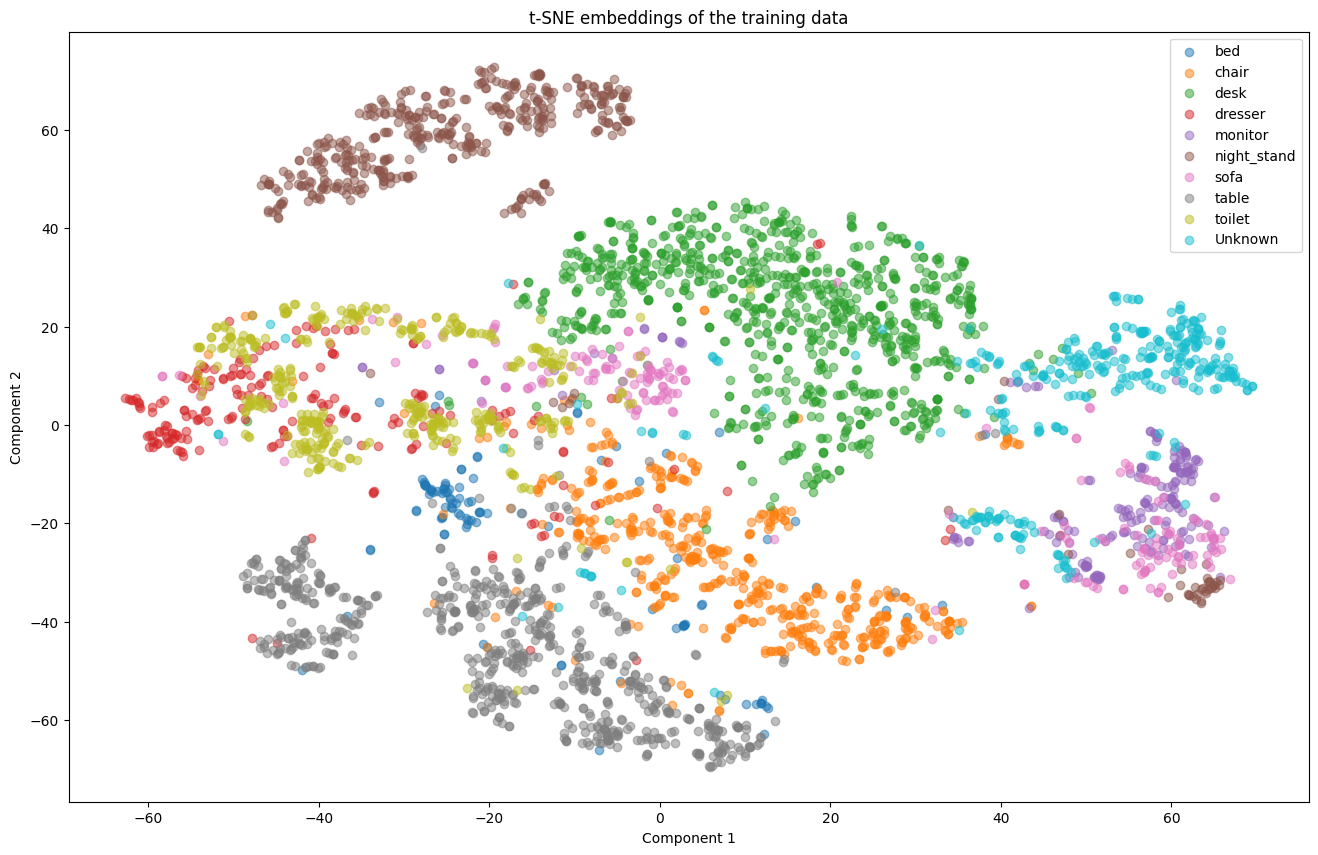

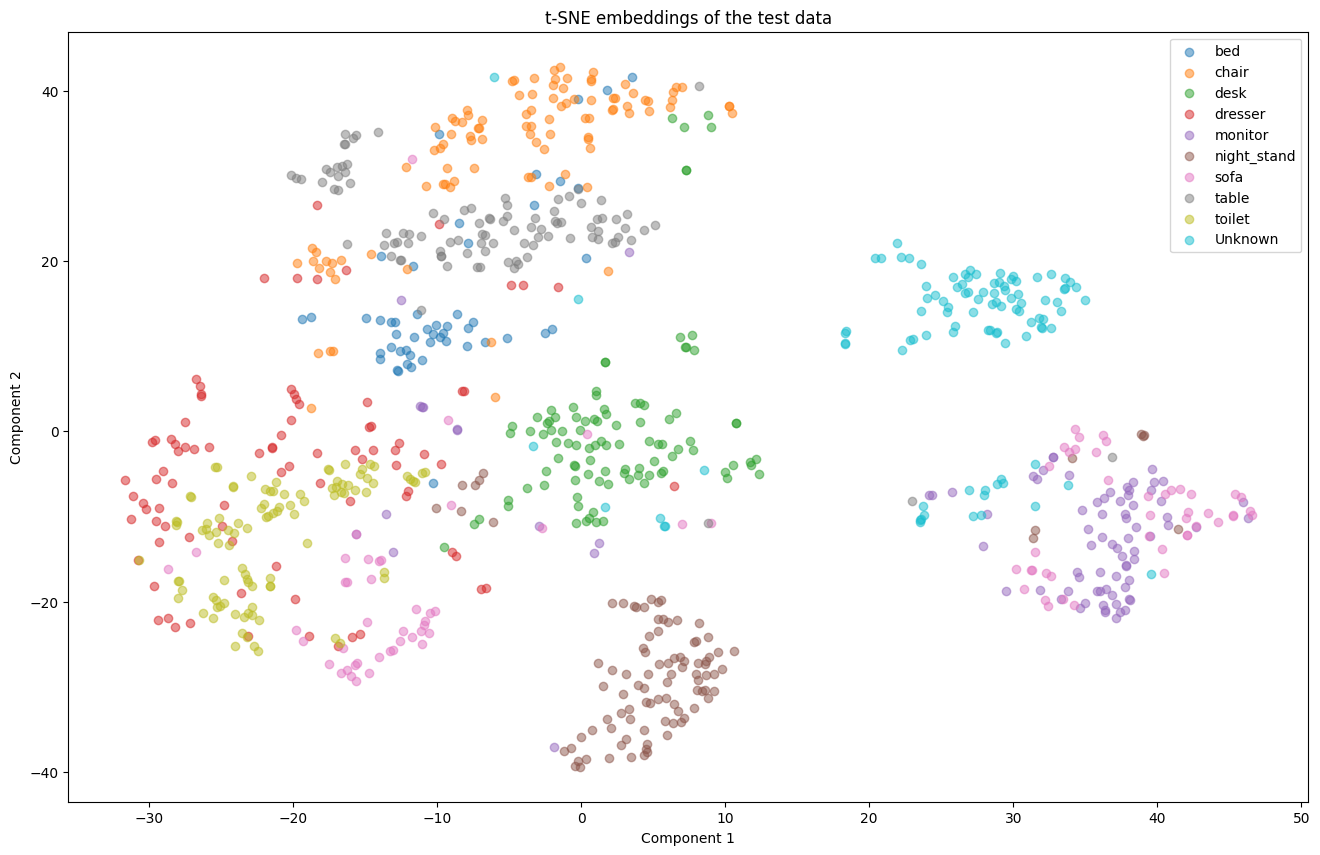

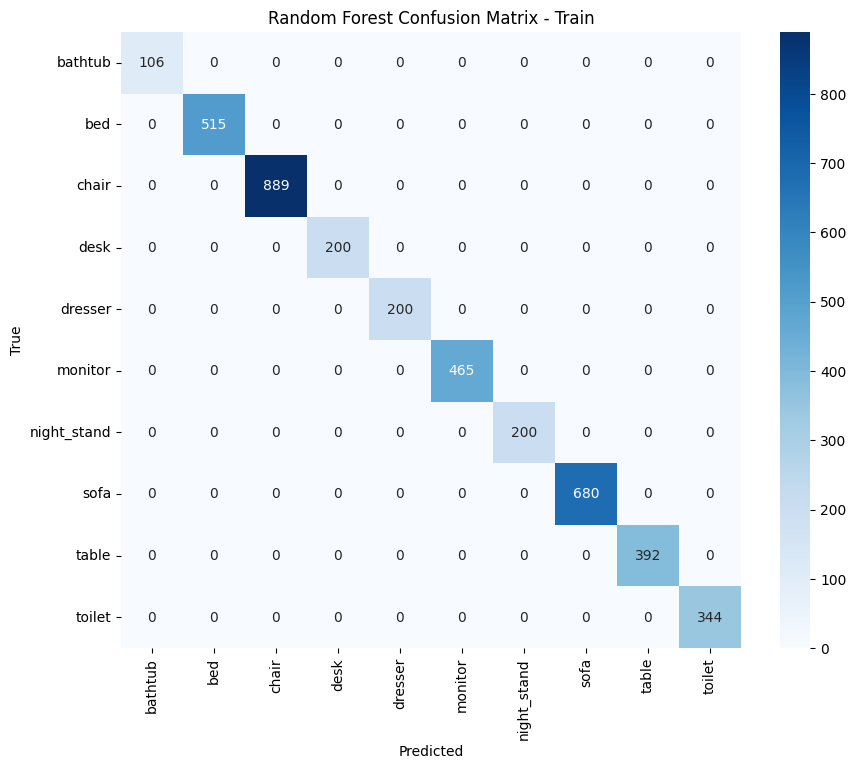

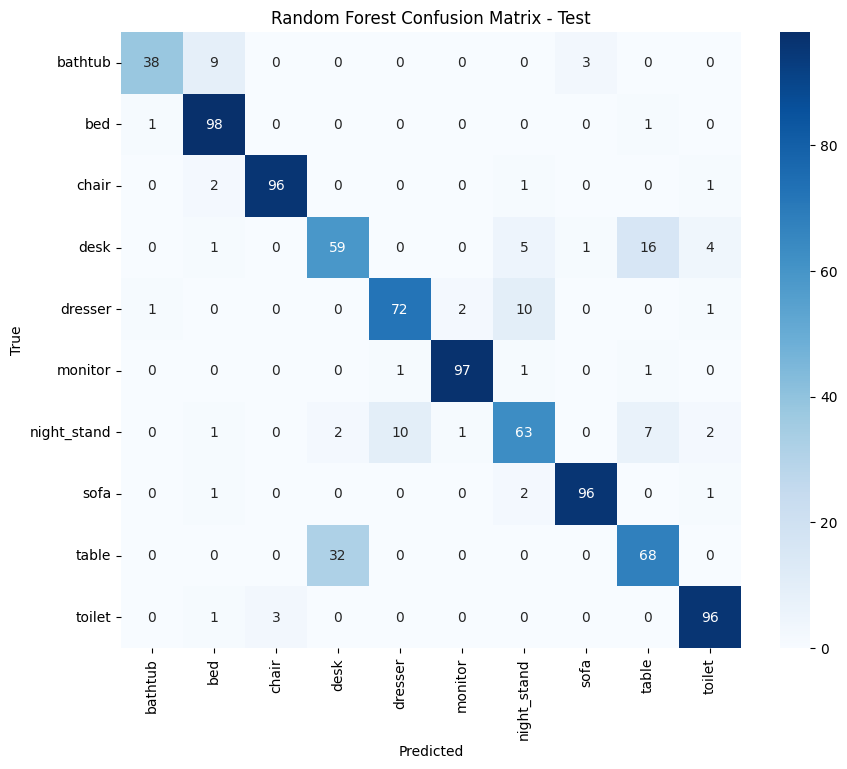

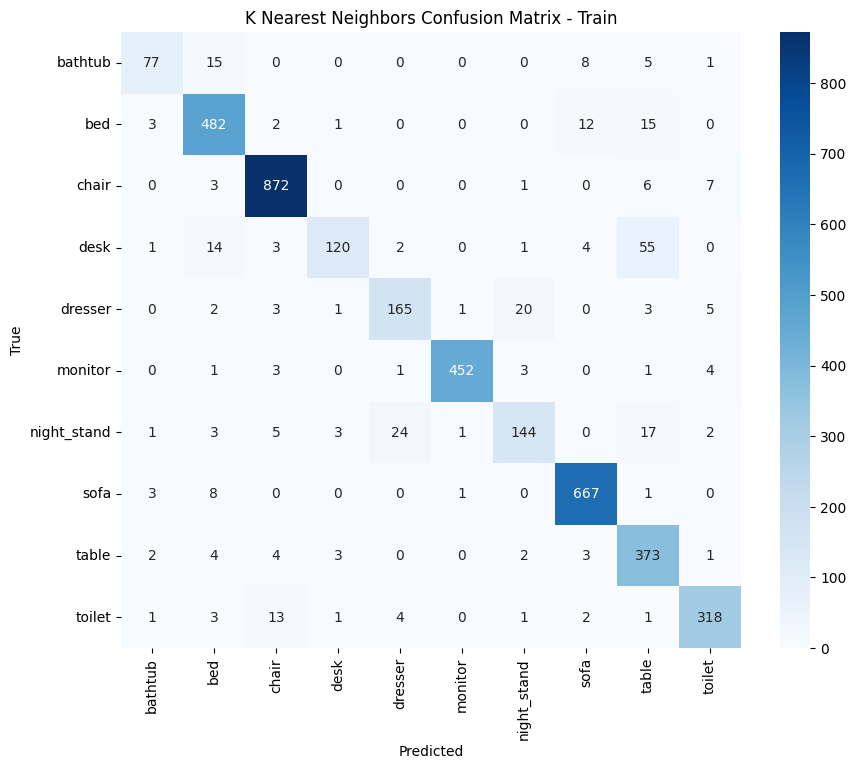

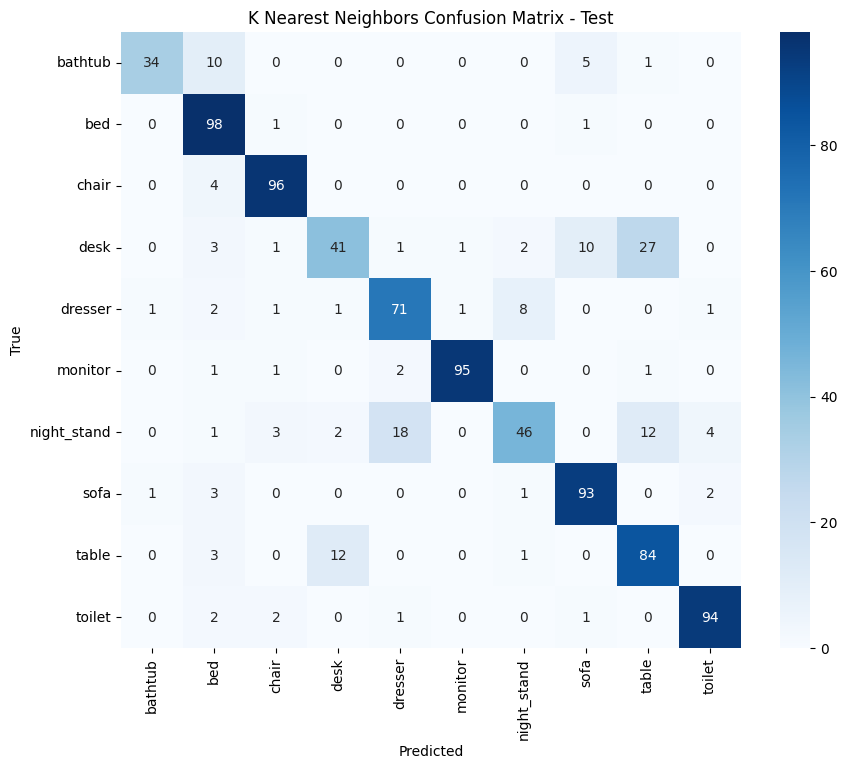

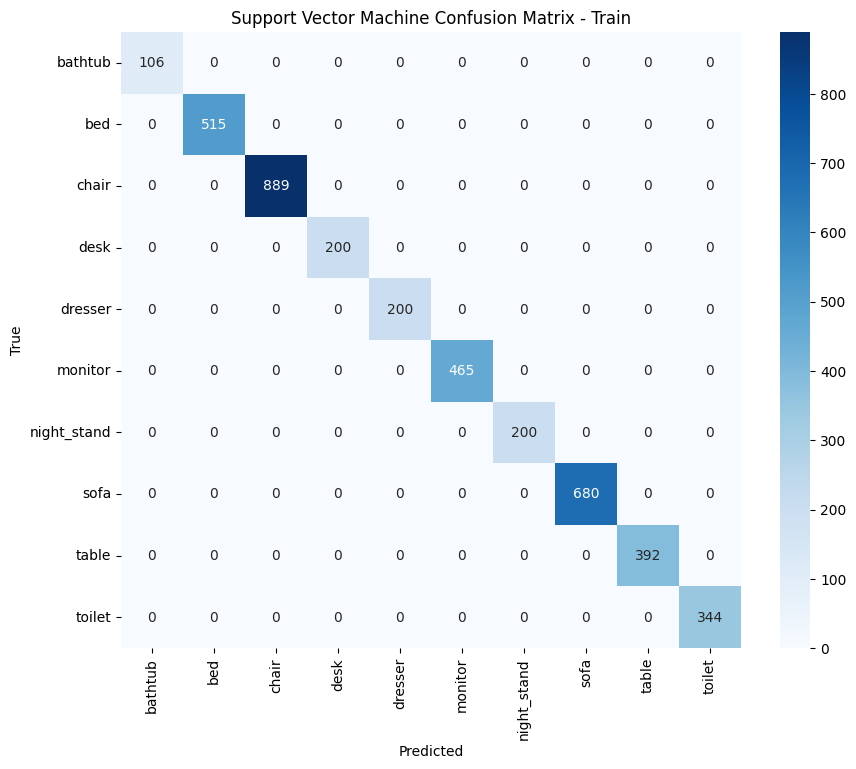

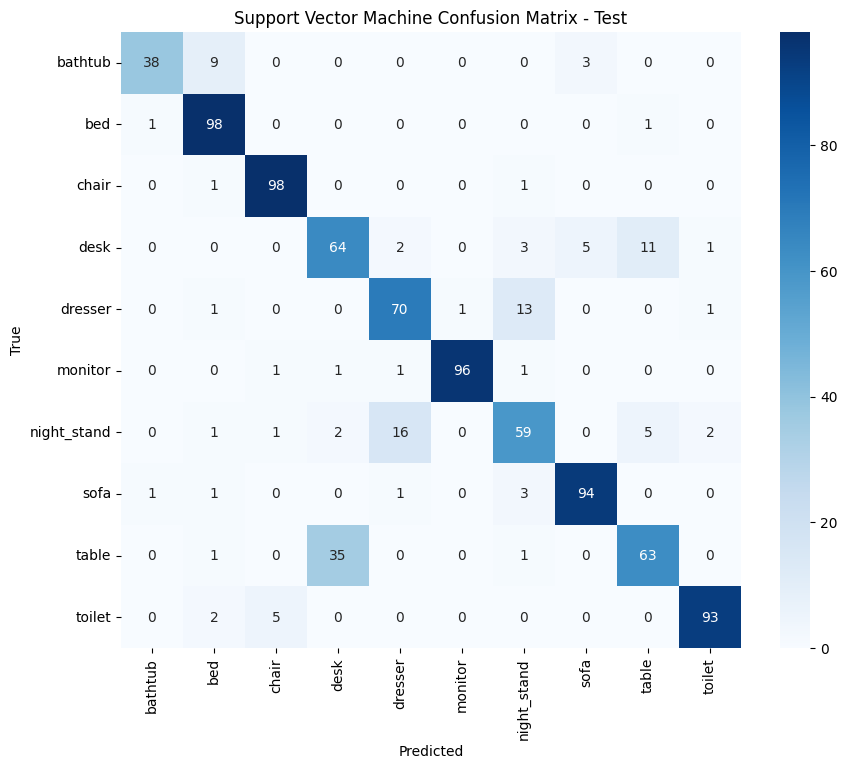

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc
import seaborn as sns

# Load the encoder model
encoder_model_path = '/content/drive/MyDrive/Colab Notebooks/models/v5_3Dautoencoder_model'
encoder_model = tf.keras.models.load_model(encoder_model_path, compile=False)

def extract_features(model, voxels):
    features = model.predict(voxels)
    return features

# # Load dataset (modelnet10)
# file_path = '/content/drive/MyDrive/Colab Notebooks/ModelNet10_res30_raw.mat'
# data = h5py.File(file_path)

# train_data = np.transpose(data['train'])
# test_data = np.transpose(data['test'])

# # Preprocess data
# def preprocess_data(data):
#     labels = data[:, 0].astype('int32')
#     voxels = data[:, 1:].reshape((-1, 30, 30, 30, 1)).astype('float32')
#     return voxels, labels

# train_voxels, train_labels = preprocess_data(train_data)
# test_voxels, test_labels = preprocess_data(test_data)

# ModelNet10 dataset information
class_names = ['bathtub', 'bed', 'chair', 'desk', 'dresser',
               'monitor', 'night_stand', 'sofa', 'table', 'toilet']
class_indices = {name: idx for idx, name in enumerate(class_names)}

# Helper function to get class name from index
def get_class_name(label_index):
    # Ensure the label index is within the range of class_names
    if 0 <= label_index < len(class_names):
        return class_names[int(label_index)]
    else:
        return "Unknown"  # Return a placeholder if the index is out of range

# Extract features using encoder model
train_features = extract_features(encoder_model, train_voxels)
test_features = extract_features(encoder_model, test_voxels)

train_features = train_features.reshape(train_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

# Train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_features, train_labels)

# Evaluate Random Forest
rf_score = rf_classifier.score(test_features, test_labels)
print(f'Random Forest Test Accuracy: {rf_score}')

# Train Gradient Boosting classifier
# gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
# gb_classifier.fit(train_features, train_labels)

# Evaluate Gradient Boosting
# gb_score = gb_classifier.score(test_features, test_labels)
# print(f'Gradient Boosting Test Accuracy: {gb_score}')

# Train K Nearest Neighbors classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features, train_labels)

# Evaluate K Nearest Neighbors
knn_score = knn_classifier.score(test_features, test_labels)
print(f'K Nearest Neighbors Test Accuracy: {knn_score}')

# Train Support Vector Machine classifier
svm_classifier = SVC(kernel='linear', probability=True, random_state=42)
svm_classifier.fit(train_features, train_labels)

# Evaluate Support Vector Machine
svm_score = svm_classifier.score(test_features, test_labels)
print(f'Support Vector Machine Test Accuracy: {svm_score}')

# TSNE embeddings
tsne = TSNE(n_components=2, random_state=0)
train_tsne_embeddings = tsne.fit_transform(train_features)
test_tsne_embeddings = tsne.fit_transform(test_features)

# Plot t-SNE embeddings for training data
plt.figure(figsize=(16, 10))
for label_index in np.unique(train_labels):
    indices = train_labels == label_index
    plt.scatter(train_tsne_embeddings[indices, 0], train_tsne_embeddings[indices, 1], label=get_class_name(label_index), alpha=0.5)
plt.legend()
plt.title('t-SNE embeddings of the training data')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

# Plot t-SNE embeddings for test data
plt.figure(figsize=(16, 10))
for label_index in np.unique(test_labels):
    indices = test_labels == label_index
    plt.scatter(test_tsne_embeddings[indices, 0], test_tsne_embeddings[indices, 1], label=get_class_name(label_index), alpha=0.5)
plt.legend()
plt.title('t-SNE embeddings of the test data')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

# Confusion Matrix
def plot_confusion_matrix(matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# # Helper function to get class name from index
# def get_class_name(label_index):
#     if 0 <= label_index < len(class_names):
#         return class_names[int(label_index)]
#     else:
#         return "Unknown"

# Confusion Matrix
rf_train_cm = confusion_matrix(train_labels, rf_classifier.predict(train_features))
rf_test_cm = confusion_matrix(test_labels, rf_classifier.predict(test_features))

plot_confusion_matrix(rf_train_cm, "Random Forest Confusion Matrix - Train")
plot_confusion_matrix(rf_test_cm, "Random Forest Confusion Matrix - Test")

# gb_train_cm = confusion_matrix(train_labels, gb_classifier.predict(train_features))
# gb_test_cm = confusion_matrix(test_labels, gb_classifier.predict(test_features))

# plot_confusion_matrix(gb_train_cm, "Gradient Boosting Confusion Matrix - Train")
# plot_confusion_matrix(gb_test_cm, "Gradient Boosting Confusion Matrix - Test")

knn_train_cm = confusion_matrix(train_labels, knn_classifier.predict(train_features))
knn_test_cm = confusion_matrix(test_labels, knn_classifier.predict(test_features))

plot_confusion_matrix(knn_train_cm, "K Nearest Neighbors Confusion Matrix - Train")
plot_confusion_matrix(knn_test_cm, "K Nearest Neighbors Confusion Matrix - Test")

svm_train_cm = confusion_matrix(train_labels, svm_classifier.predict(train_features))
svm_test_cm = confusion_matrix(test_labels, svm_classifier.predict(test_features))

plot_confusion_matrix(svm_train_cm, "Support Vector Machine Confusion Matrix - Train")
plot_confusion_matrix(svm_test_cm, "Support Vector Machine Confusion Matrix - Test")

# Classification Report
rf_train_report = classification_report(train_labels, rf_classifier.predict(train_features), target_names=class_names, output_dict=True)
rf_test_report = classification_report(test_labels, rf_classifier.predict(test_features), target_names=class_names, output_dict=True)

# gb_train_report = classification_report(train_labels, gb_classifier.predict(train_features), target_names=class_names, output_dict=True)
# gb_test_report = classification_report(test_labels, gb_classifier.predict(test_features), target_names=class_names, output_dict=True)

knn_train_report = classification_report(train_labels, knn_classifier.predict(train_features), target_names=class_names, output_dict=True)
knn_test_report = classification_report(test_labels, knn_classifier.predict(test_features), target_names=class_names, output_dict=True)

svm_train_report = classification_report(train_labels, svm_classifier.predict(train_features), target_names=class_names, output_dict=True)
svm_test_report = classification_report(test_labels, svm_classifier.predict(test_features), target_names=class_names, output_dict=True)



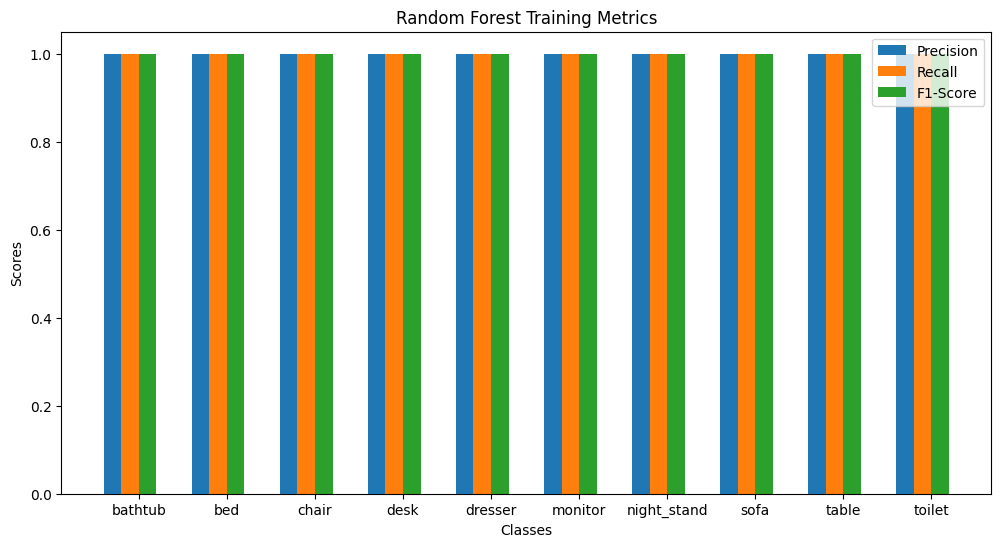

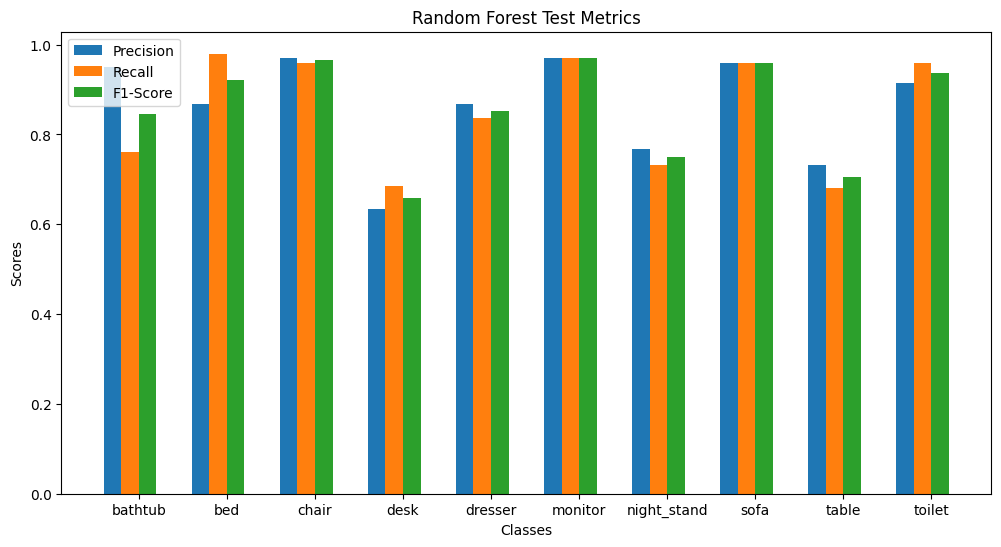

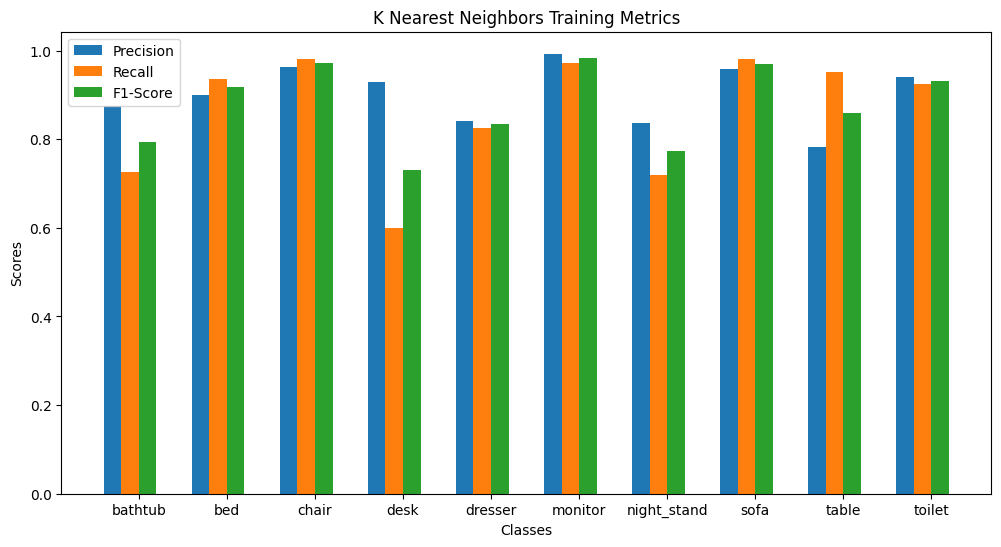

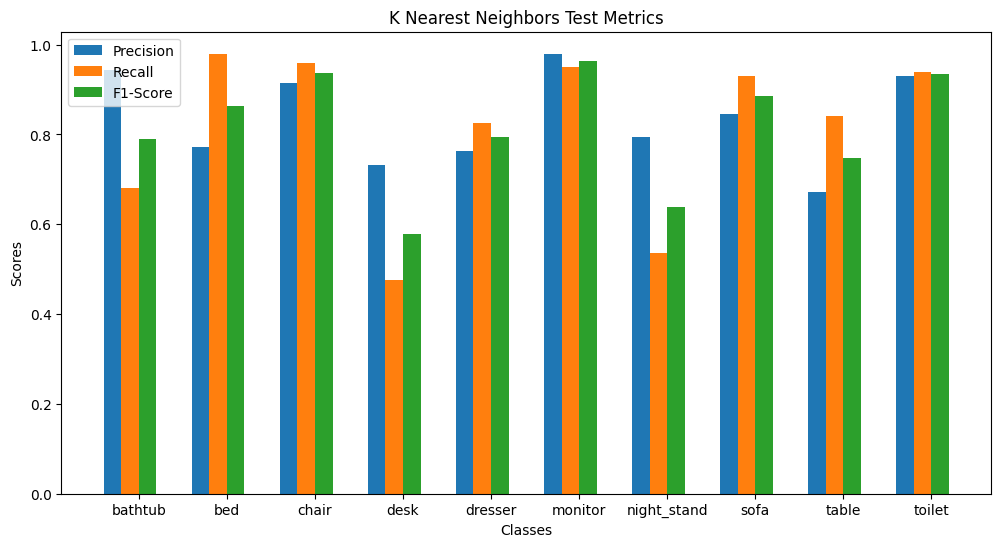

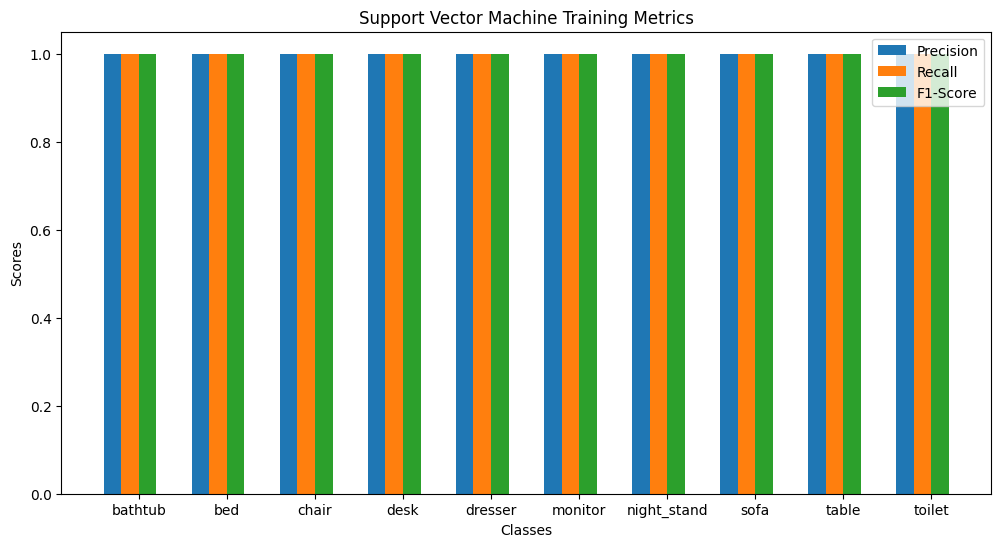

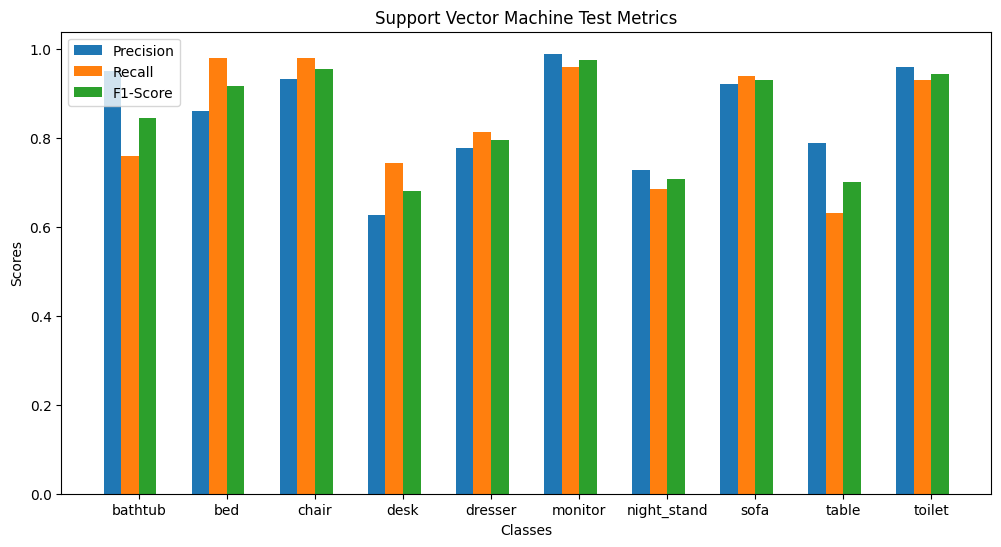

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


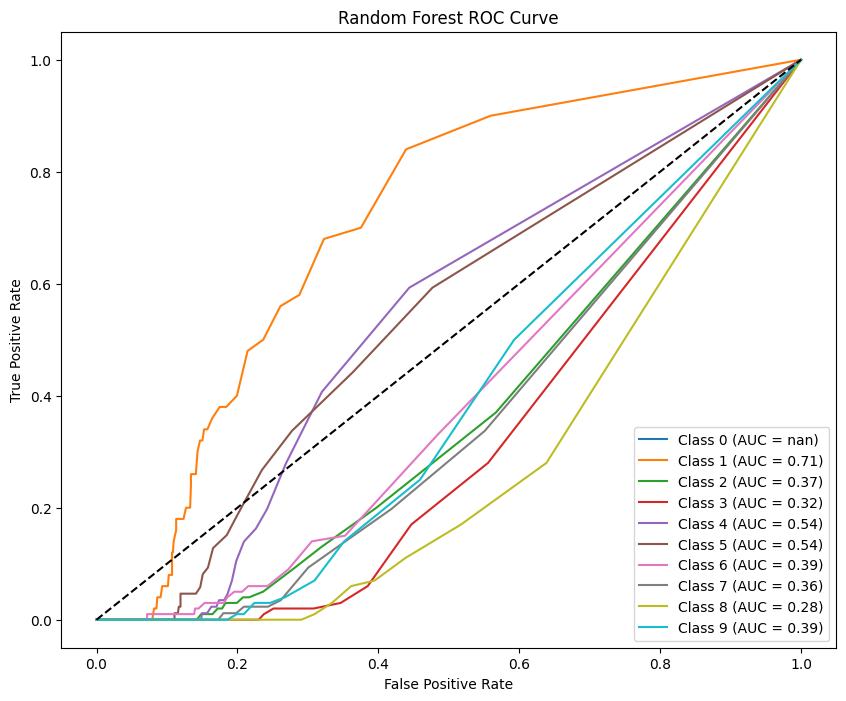

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


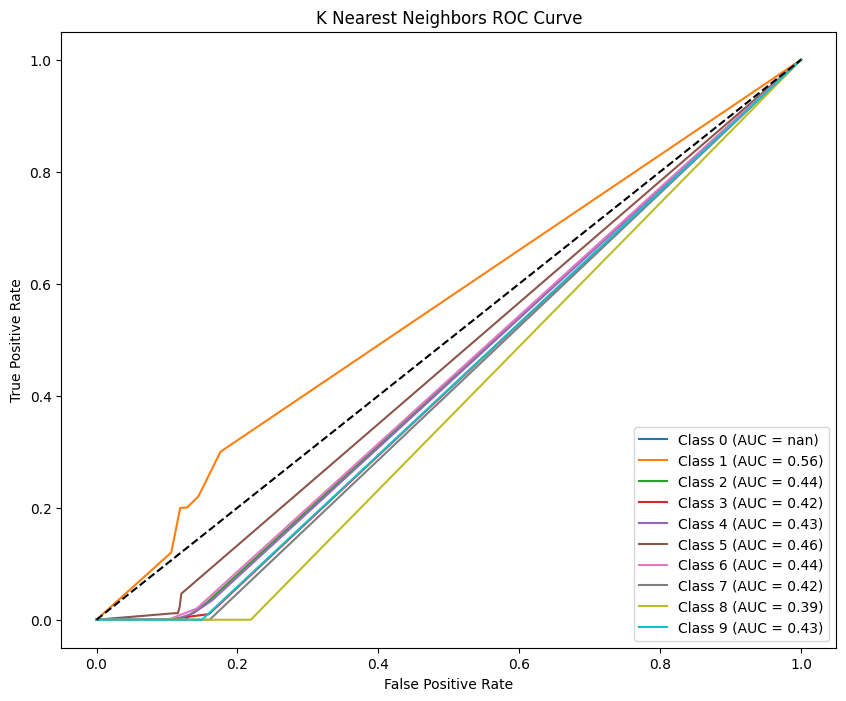

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


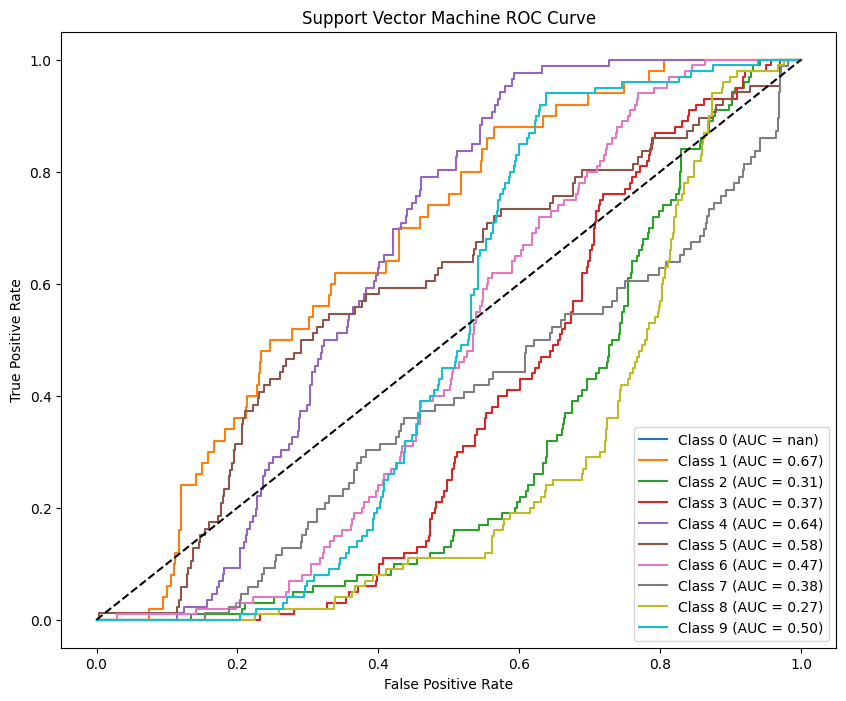

In [ ]:

def plot_metrics(metrics, title):
    classes = [cls for cls in metrics.keys() if cls not in ['accuracy', 'macro avg', 'weighted avg']]
    precision = [metrics[cls]['precision'] for cls in classes]
    recall = [metrics[cls]['recall'] for cls in classes]
    f1_score = [metrics[cls]['f1-score'] for cls in classes]

    bar_width = 0.2
    x = np.arange(len(classes))

    plt.figure(figsize=(12, 6))
    plt.bar(x, precision, width=bar_width, label='Precision')
    plt.bar(x + bar_width, recall, width=bar_width, label='Recall')
    plt.bar(x + 2 * bar_width, f1_score, width=bar_width, label='F1-Score')

    plt.xlabel('Classes')
    plt.ylabel('Scores')
    plt.title(title)
    plt.xticks([i + 1.5 * bar_width for i in x], classes)
    plt.legend()
    plt.show()

plot_metrics(rf_train_report, "Random Forest Training Metrics")
plot_metrics(rf_test_report, "Random Forest Test Metrics")

# plot_metrics(gb_train_report, "Gradient Boosting Training Metrics")
# plot_metrics(gb_test_report, "Gradient Boosting Test Metrics")

plot_metrics(knn_train_report, "K Nearest Neighbors Training Metrics")
plot_metrics(knn_test_report, "K Nearest Neighbors Test Metrics")

plot_metrics(svm_train_report, "Support Vector Machine Training Metrics")
plot_metrics(svm_test_report, "Support Vector Machine Test Metrics")

# ROC Curve
def plot_roc_curve(y_true, y_score, title):
    n_classes = len(np.unique(y_true))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true, y_score[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Calculate the probability scores
rf_test_probs = rf_classifier.predict_proba(test_features)
# gb_test_probs = gb_classifier.predict_proba(test_features)
knn_test_probs = knn_classifier.predict_proba(test_features)
svm_test_probs = svm_classifier.predict_proba(test_features)

plot_roc_curve(test_labels, rf_test_probs, "Random Forest ROC Curve")
# plot_roc_curve(test_labels, gb_test_probs, "Gradient Boosting ROC Curve")
plot_roc_curve(test_labels, knn_test_probs, "K Nearest Neighbors ROC Curve")
plot_roc_curve(test_labels, svm_test_probs, "Support Vector Machine ROC Curve")


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Predict labels using trained SVM classifier
train_predictions = svm_classifier.predict(train_features)
test_predictions = svm_classifier.predict(test_features)

# Calculate precision, recall, and F1 score for training set
train_precision = precision_score(train_labels, train_predictions, average='weighted')
train_recall = recall_score(train_labels, train_predictions, average='weighted')
train_f1_score = f1_score(train_labels, train_predictions, average='weighted')
train_accuracy = accuracy_score(train_labels, train_predictions)

print("Training Metrics:")
print("SVM:")
print(f'Training Precision: {train_precision}')
print(f'Training Recall: {train_recall}')
print(f'Training F1 Score: {train_f1_score}')
print(f'Training Accuracy: {train_accuracy}')

# Calculate precision, recall, and F1 score for testing set
test_precision = precision_score(test_labels, test_predictions, average='weighted')
test_recall = recall_score(test_labels, test_predictions, average='weighted')
test_f1_score = f1_score(test_labels, test_predictions, average='weighted')
test_accuracy = accuracy_score(test_labels, test_predictions)

print("\nTesting Metrics:")
print("SVM:")
print(f'Testing Precision: {test_precision}')
print(f'Testing Recall: {test_recall}')
print(f'Testing F1 Score: {test_f1_score}')
print(f'Testing Accuracy: {test_accuracy}')

Training Metrics:
SVM:
Training Precision: 1.0
Training Recall: 1.0
Training F1 Score: 1.0
Training Accuracy: 1.0

Testing Metrics:
SVM:
Testing Precision: 0.85467193578759
Testing Recall: 0.8513215859030837
Testing F1 Score: 0.8503270840862981
Testing Accuracy: 0.8513215859030837


In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


rf_test_predictions = rf_classifier.predict(test_features)


rf_train_precision = precision_score(train_labels, rf_classifier.predict(train_features), average='weighted')
rf_train_recall = recall_score(train_labels, rf_classifier.predict(train_features), average='weighted')
rf_train_f1 = f1_score(train_labels, rf_classifier.predict(train_features), average='weighted')

print("Training Metrics:")
print("Random Forest:")
print(f"Precision: {rf_train_precision}")
print(f"Recall: {rf_train_recall}")
print(f"F1 Score: {rf_train_f1}")
print(f"Accuracy: {rf_classifier.score(train_features, train_labels)}")

rf_test_accuracy = accuracy_score(test_labels, rf_test_predictions)
rf_test_precision = precision_score(test_labels, rf_test_predictions, average='weighted')
rf_test_recall = recall_score(test_labels, rf_test_predictions, average='weighted')
rf_test_f1 = f1_score(test_labels, rf_test_predictions, average='weighted')

print("\nTesting Metrics:")
print("Random Forest:")
print(f"Precision: {rf_test_precision}")
print(f"Recall: {rf_test_recall}")
print(f"F1 Score: {rf_test_f1}")
print(f"Accuracy: {rf_test_accuracy}")

Training Metrics:
Random Forest:
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Accuracy: 1.0

Testing Metrics:
Random Forest:
Precision: 0.8634107178856639
Recall: 0.8623348017621145
F1 Score: 0.8615849288471137
Accuracy: 0.8623348017621145


In [ ]:

knn_test_predictions = knn_classifier.predict(test_features)


knn_train_precision = precision_score(train_labels, knn_classifier.predict(train_features), average='weighted')
knn_train_recall = recall_score(train_labels, knn_classifier.predict(train_features), average='weighted')
knn_train_f1 = f1_score(train_labels, knn_classifier.predict(train_features), average='weighted')

print("\nK-Nearest Neighbors:")
print(f"Precision: {knn_train_precision}")
print(f"Recall: {knn_train_recall}")
print(f"F1 Score: {knn_train_f1}")
print(f"Accuracy: {knn_classifier.score(train_features, train_labels)}")

knn_test_accuracy = accuracy_score(test_labels, knn_test_predictions)
knn_test_precision = precision_score(test_labels, knn_test_predictions, average='weighted')
knn_test_recall = recall_score(test_labels, knn_test_predictions, average='weighted')
knn_test_f1 = f1_score(test_labels, knn_test_predictions, average='weighted')

print("\nK-Nearest Neighbors:")
print(f"Precision: {knn_test_precision}")
print(f"Recall: {knn_test_recall}")
print(f"F1 Score: {knn_test_f1}")
print(f"Accuracy: {knn_test_accuracy}")


K-Nearest Neighbors:
Precision: 0.9218112379431777
Recall: 0.919569030318216
F1 Score: 0.9175792519210428
Accuracy: 0.919569030318216

K-Nearest Neighbors:
Precision: 0.8319340859383825
Recall: 0.8281938325991189
F1 Score: 0.8211278046892578
Accuracy: 0.8281938325991189


In [ ]:
gb_test_predictions = gb_classifier.predict(test_features)


gb_train_precision = precision_score(train_labels, gb_classifier.predict(train_features), average='weighted')
gb_train_recall = recall_score(train_labels, gb_classifier.predict(train_features), average='weighted')
gb_train_f1 = f1_score(train_labels, gb_classifier.predict(train_features), average='weighted')

print("\nGradient Boosting:")
print(f"Precision: {gb_train_precision}")
print(f"Recall: {gb_train_recall}")
print(f"F1 Score: {gb_train_f1}")
print(f"Accuracy: {gb_classifier.score(train_features, train_labels)}")

gb_test_accuracy = accuracy_score(test_labels, gb_test_predictions)
gb_test_precision = precision_score(test_labels, gb_test_predictions, average='weighted')
gb_test_recall = recall_score(test_labels, gb_test_predictions, average='weighted')
gb_test_f1 = f1_score(test_labels, gb_test_predictions, average='weighted')

print("\nGradient Boosting:")
print(f"Precision: {gb_test_precision}")
print(f"Recall: {gb_test_recall}")
print(f"F1 Score: {gb_test_f1}")
print(f"Accuracy: {gb_test_accuracy}")


Gradient Boosting:
Precision: 0.9980141417886594
Recall: 0.9979954898521674
F1 Score: 0.9979967600269877
Accuracy: 0.9979954898521674

Gradient Boosting:
Precision: 0.8564734820679063
Recall: 0.8524229074889867
F1 Score: 0.8491061950150702
Accuracy: 0.8524229074889867


In [ ]:
import joblib

svm_save_path = '/content/drive/MyDrive/Colab Notebooks/models/v5_3DCat_svm_model.joblib'

# Save the SVM model
joblib.dump(svm_classifier, svm_save_path)

['/content/drive/MyDrive/Colab Notebooks/models/v5_3DCat_svm_model.joblib']

end of code

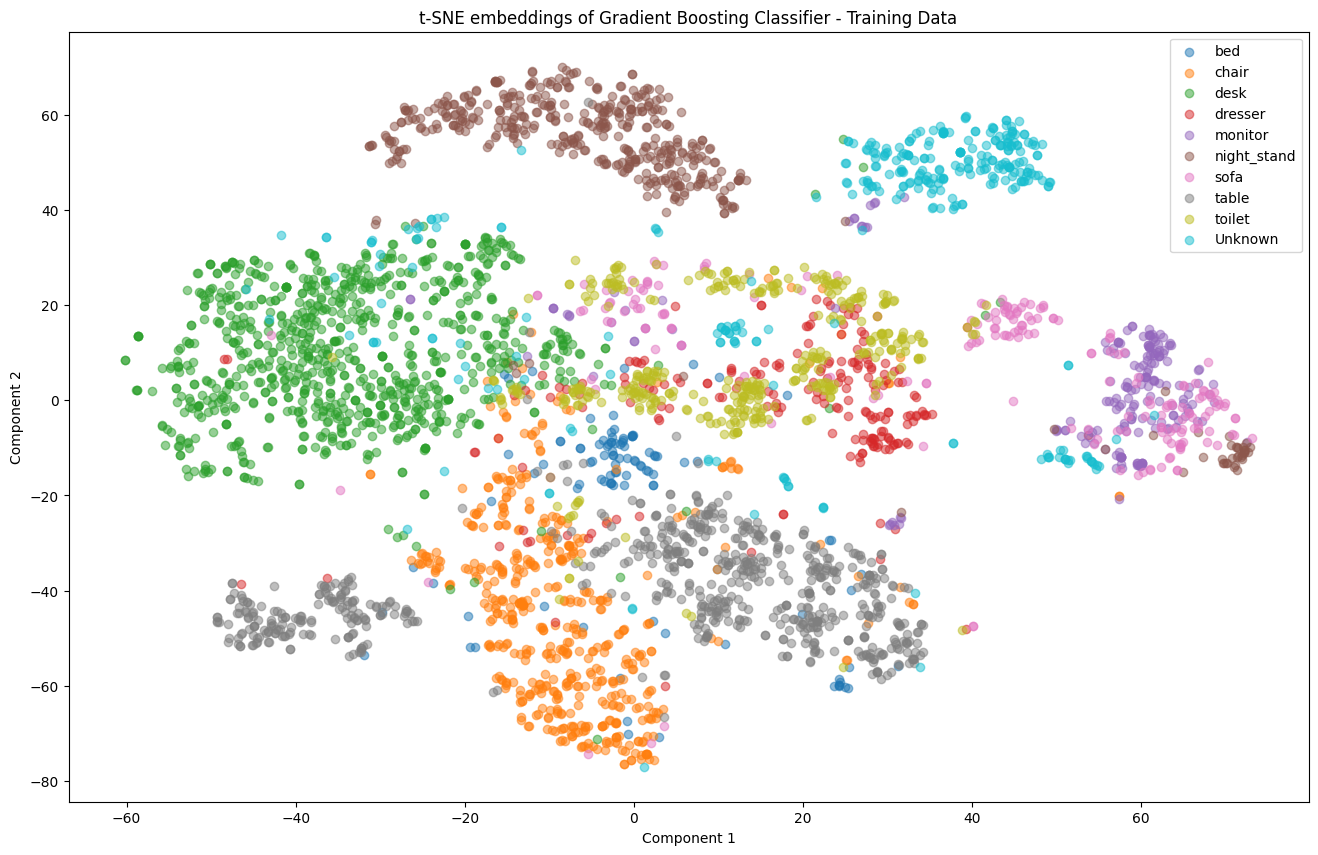

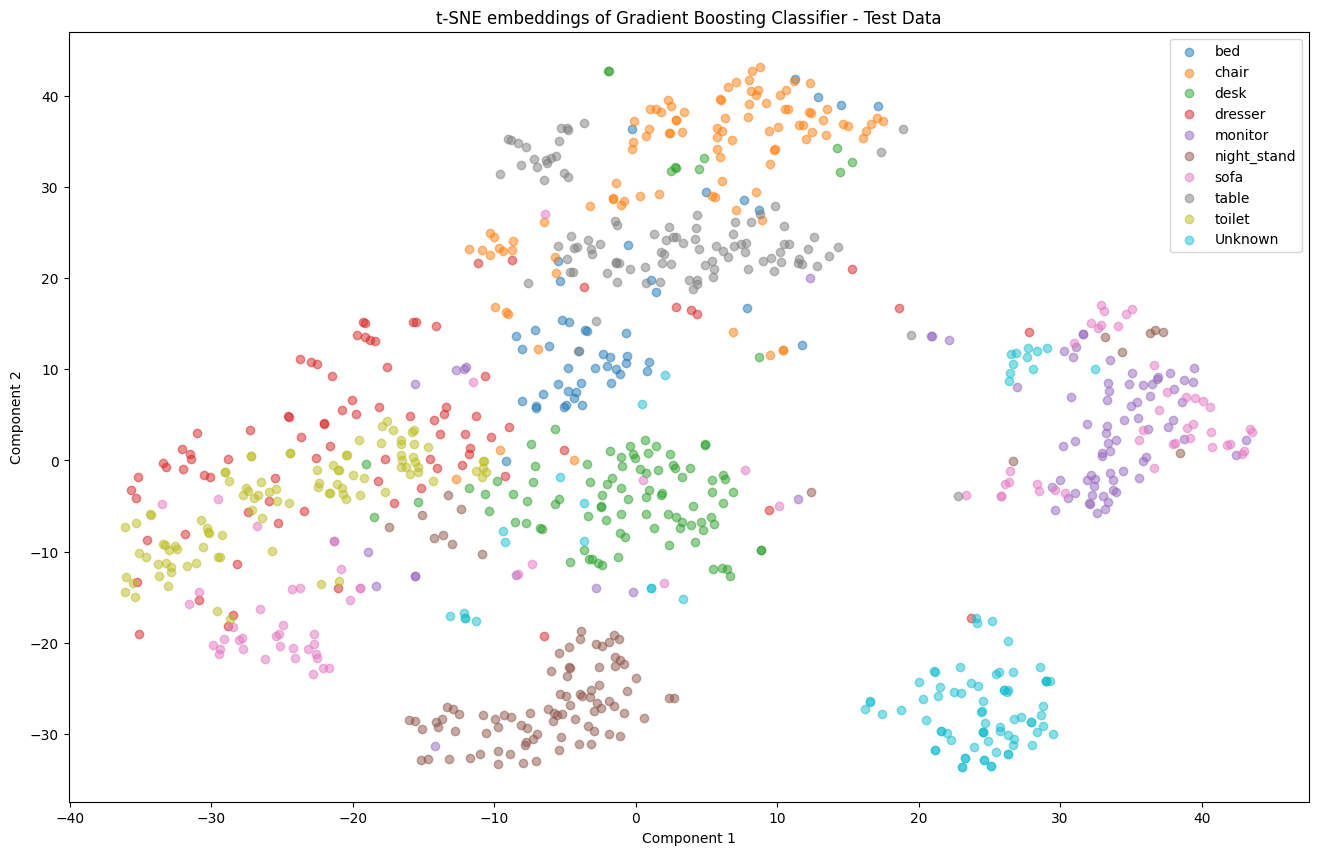

In [ ]:
# Plot t-SNE embeddings for Gradient Boosting Classifier - Training data
plt.figure(figsize=(16, 10))
for label_index in np.unique(train_labels):
    indices = train_labels == label_index
    plt.scatter(gb_train_tsne_embeddings[indices, 0], gb_train_tsne_embeddings[indices, 1], label=get_class_name(label_index), alpha=0.5)
plt.legend()
plt.title('t-SNE embeddings of Gradient Boosting Classifier - Training Data')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

# Plot t-SNE embeddings for Gradient Boosting Classifier - Test data
plt.figure(figsize=(16, 10))
for label_index in np.unique(test_labels):
    indices = test_labels == label_index
    plt.scatter(gb_test_tsne_embeddings[indices, 0], gb_test_tsne_embeddings[indices, 1], label=get_class_name(label_index), alpha=0.5)
plt.legend()
plt.title('t-SNE embeddings of Gradient Boosting Classifier - Test Data')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

# Custom 3D Models

In [ ]:
!pip install git+https://github.com/omkar-mohanty/PyVoxelizer
!pip install git+https://github.com/p-hofmann/MeshReader.git#egg=meshlib
!pip install meshlib>=0.0.2

  Cloning https://github.com/omkar-mohanty/PyVoxelizer to /tmp/pip-req-build-gs04pwri
  Running command git clone --filter=blob:none --quiet https://github.com/omkar-mohanty/PyVoxelizer /tmp/pip-req-build-gs04pwri
  Resolved https://github.com/omkar-mohanty/PyVoxelizer to commit 59c4f47224a46588903657749ea7f818667f58c2
  Preparing metadata (setup.py) ... done
  Created wheel for voxlib: filename=voxlib-0.0.5-py3-none-any.whl size=9577 sha256=6395e42c09c70d59232763a100c0f658e0981b07f825e4924053a9c1bef7e418
  Stored in directory: /tmp/pip-ephem-wheel-cache-xvk1ymx4/wheels/12/eb/1a/e50e44cc9e3b1b425c7499199b706535ae65ef9abcb0fdf0d0
Successfully built voxlib
  Cloning https://github.com/p-hofmann/MeshReader.git to /tmp/pip-install-2j5fvuei/meshlib_2d220b896b724c23a73d9173d4fd190b
  Running command git clone --filter=blob:none --quiet https://github.com/p-hofmann/MeshReader.git /tmp/pip-install-2j5fvuei/meshlib_2d220b896b724c23a73d9173d4fd190b
  Resolved https://github.com/p-hofmann/MeshRea

In [ ]:
import voxlib.voxelize
import matplotlib.pyplot as plt
import numpy as np

def plot_voxel_grid(matrix):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    filled = np.array(matrix) == 1.0  # Convert the 3D matrix to a numpy array for compatibility
    ax.voxels(filled, facecolors='blue', edgecolor='k')
    plt.show()

class VoxelModel:
  """
    filename: Must end with .stl
    dim: must be even
  """
  def __init__(self, filename, dim):
    self.mat = normvox(filename, dim)
    self.dim = dim

  def show_3d(self):
    plot_voxel_grid(self.mat)

"""
Voxelize function outputs (x,y,z) coordinates where the voxel exists, but we need the full dim * dim * dim 3D matrix.
This function initializes a matrix of size dim * dim * dim then fills it up with all zeros first. Then loops over the filled voxel
coordinates and puts 1.0 into them.
"""

def normvox(filename, dim):
    coordinates = voxlib.voxelize.voxelize(filename, dim)

    matrix_size = (dim, dim , dim)
    matrix = [[[0.0 for _ in range(matrix_size[2])] for _ in range(matrix_size[1])] for _ in range(matrix_size[0])]

    for coord in coordinates:

      x, y, z = coord
      "Works for even dimensions only"
      x += int(dim/2) - 1
      y += int(dim/2) - 1
      z += int(dim/2) - 1
      matrix[x][y][z] = 1.0

    return matrix

Voxelize:  |====================| 100.0% 
Voxelize:  |====================| 100.0% 
Voxelize:  |====================| 100.0% 
Voxelize:  |====================| 100.0% 
Voxelize:  |====================| 100.0% 
Voxelize:  |====================| 100.0% 
Voxelize:  |====================| 100.0% 
Voxelize:  |====================| 100.0% 


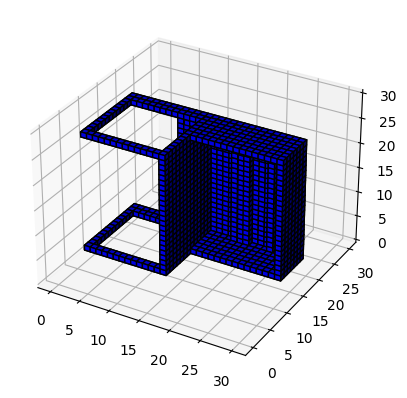

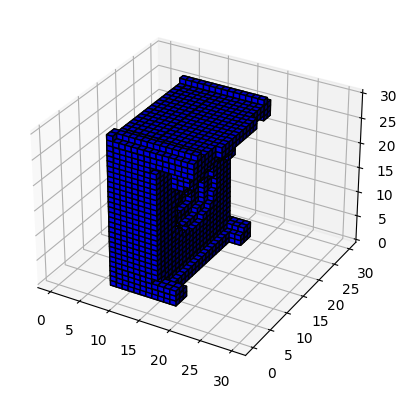

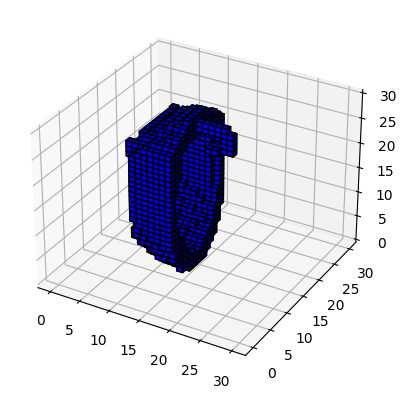

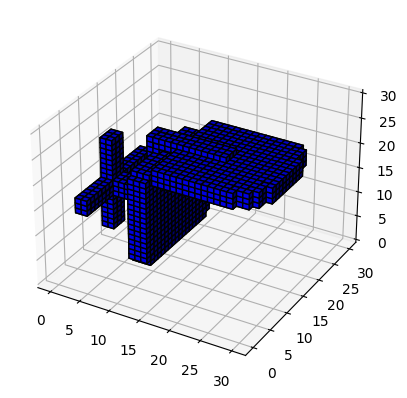

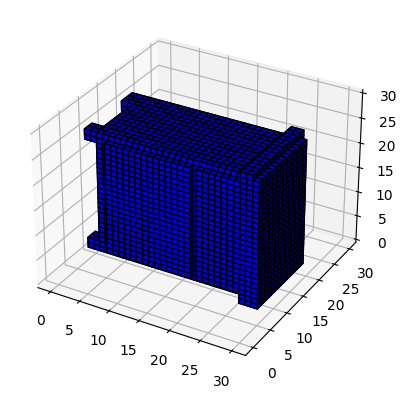

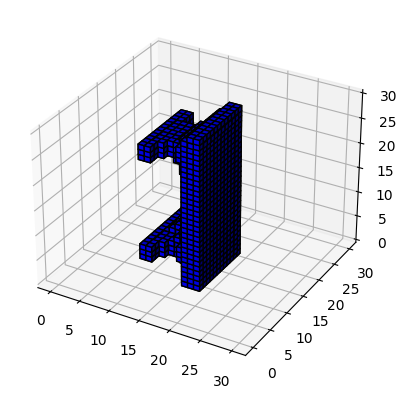

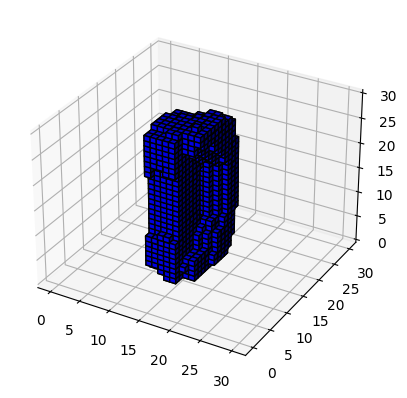

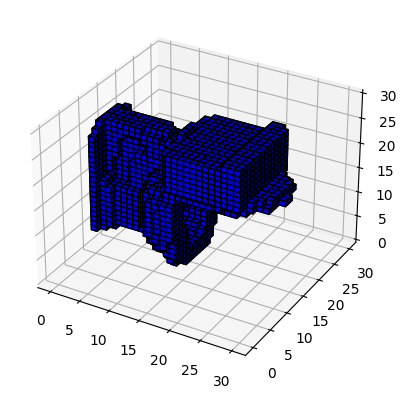

In [ ]:
import os

def load_model3d(filename, dim):
    model3d = VoxelModel(filename, dim)
    models3d.append(model3d)

models3d = []
# model3d_dir = "/content/drive/MyDrive/3D-Files"
model3d_dir = "/content/drive/MyDrive/3D-Files/selected"

# Iterate over each file in the directory and load the 3D model if it's an STL file
for file in os.listdir(model3d_dir):
    if file.endswith(".stl"):
        full_path = os.path.join(model3d_dir, file)
        load_model3d(full_path, 30)  # Load the 3D model and append it to the models3d list

for model3d in models3d:
    model3d.show_3d()


In [ ]:
import joblib

# Path to the saved models
autoencoder_save_path = '/content/drive/MyDrive/Colab Notebooks/models/v5_3Dautoencoder_model'
svm_save_path = '/content/drive/MyDrive/Colab Notebooks/models/v5_3DCat_svm_model.joblib'

# Load the autoencoder model with custom objects
loaded_autoencoder_model = tf.keras.models.load_model(
    autoencoder_save_path,
    custom_objects={'VAE3D': VAE3D, 'Encoder': Encoder, 'Decoder': Decoder}
)

# Load the SVM model
loaded_svm_classifier = joblib.load(svm_save_path)

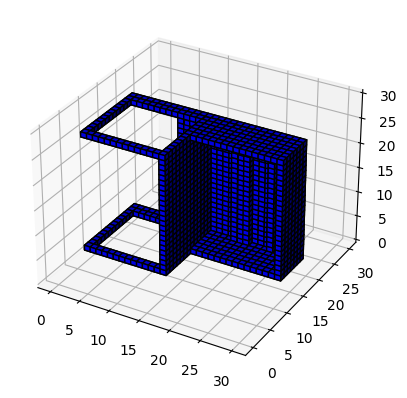

The predicted class for the model is: sofa


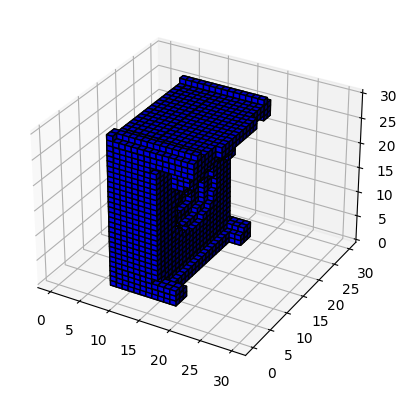

The predicted class for the model is: bed


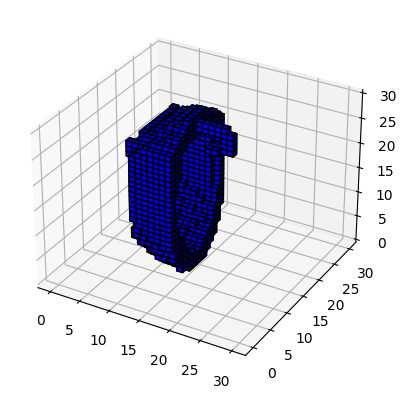

The predicted class for the model is: bathtub


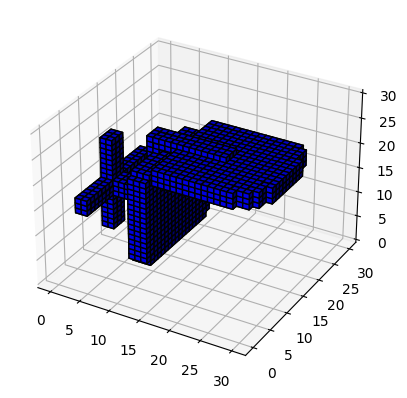

The predicted class for the model is: chair


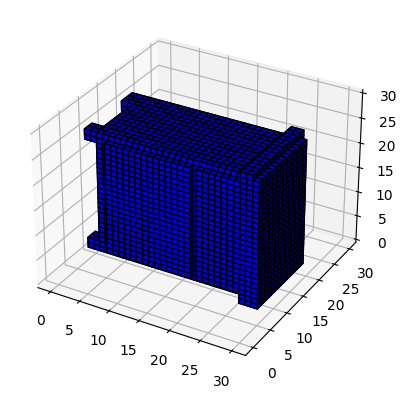

The predicted class for the model is: dresser


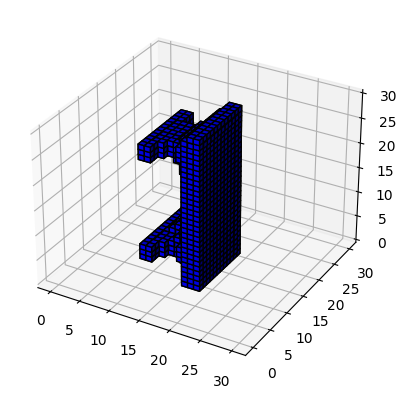

The predicted class for the model is: table


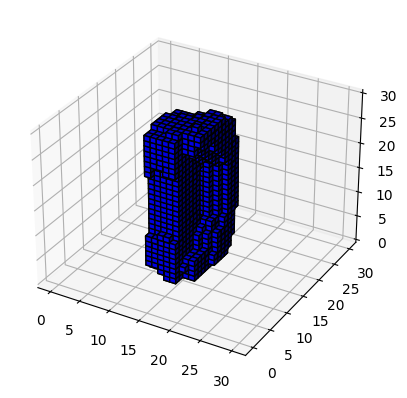

The predicted class for the model is: sofa


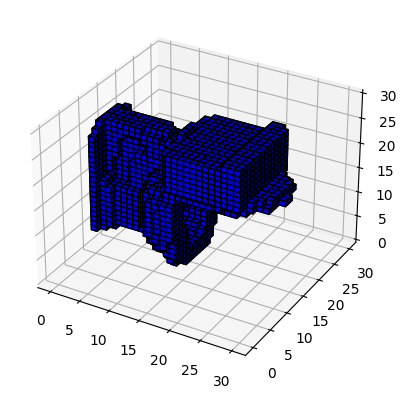

The predicted class for the model is: toilet


In [ ]:
# Correct the preprocess_new_data to accept VoxelModel instances
def preprocess_new_data(voxel_model):
    # Convert the matrix to a numpy array and add batch and channel dimensions
    new_voxel = np.expand_dims(np.array(voxel_model.mat), axis=(0, -1)).astype('float32')
    return new_voxel

def extract_features(model, voxels):
    features = model.encode(voxels).numpy()
    return features

# List of class names in the order corresponding to the class indices
class_names = ['bathtub', 'bed', 'chair', 'desk', 'dresser',
               'monitor', 'night_stand', 'sofa', 'table', 'toilet']

# Assuming `models3d` is a list of 3D model data ready to be processed
for model3d in models3d:
    model3d.show_3d() # View model
    voxelized_model3d = preprocess_new_data(model3d)
    features = extract_features(loaded_autoencoder_model, voxelized_model3d)
    # Flatten the features to remove the batch dimension
    features_flat = features.reshape(1, -1)
    predicted_class_index = loaded_svm_classifier.predict(features_flat)
    predicted_class_name = class_names[predicted_class_index[0] - 1]  # Map index to name
    print(f"The predicted class for the model is: {predicted_class_name}")